# Micrograd Demo

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

In [3]:
np.random.seed(1337)
random.seed(1337)

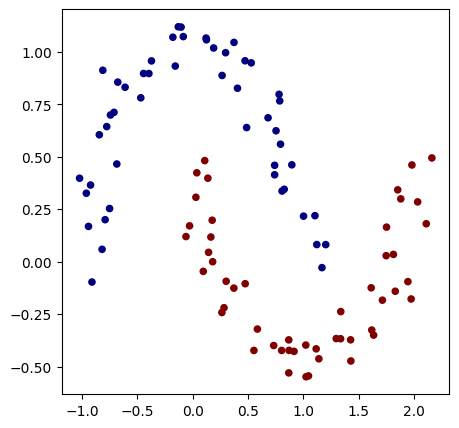

In [4]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1  # make y be -1 or 1 (from 0 or 1)
# visualise in 2d
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [36]:
# initialise a model
model = MLP(2, [16, 16, 1])
print(model)
print("Number of parameters:", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
Number of parameters: 337


In [6]:
# loss function
def loss(batch_size=None):

    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # forward the model to get scores
    scores = list(map(model, inputs))

    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))

    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)


Value(data=0.8958441028683222, grad=0) 0.5


In [37]:
# optimisation
for k in range(100):

    # forward
    total_loss, acc = loss()

    # backward
    model.zero_grad()    
    total_loss.backward()

    # update (stochastic gradient descent)
    learning_rate = 1.0 - 0.9 * k / 100
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    if k % 10 == 0:
        print(f"step {k}: loss {total_loss.data}, accuracy {acc}")


step 0: loss 1.7526969205744873, accuracy 0.33
step 10: loss 0.29185942519565994, accuracy 0.91
step 20: loss 0.19275281434159264, accuracy 0.92
step 30: loss 0.06640686083246458, accuracy 0.98
step 40: loss 0.04466614951500757, accuracy 0.98
step 50: loss 0.02951058969137144, accuracy 0.99
step 60: loss 0.011181497117745036, accuracy 1.0
step 70: loss 0.011162749509763847, accuracy 1.0
step 80: loss 0.011148046210051839, accuracy 1.0
step 90: loss 0.011137371237264722, accuracy 1.0


(-1.548639298268643, 1.951360701731357)

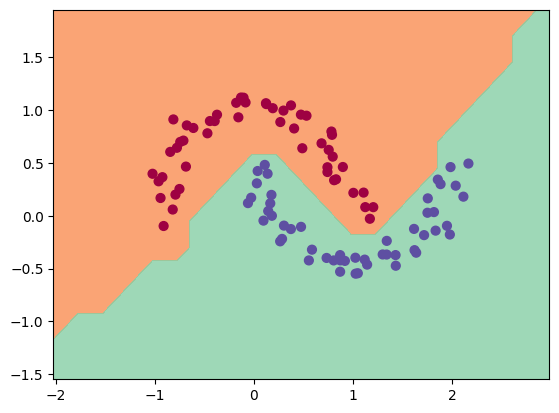

In [38]:
# visualise decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())